In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats

<h1> Research Questions </h1>

In [3]:
def get_comparison_summary(parameter):
    return pd.concat([pomodoro[parameter].describe(),exman[parameter].describe()],axis=1,keys=["pomodoro","exman"])

In [4]:
def normalize_data(data_input, normalizer, data_output, df):
    df[data_output] = df[data_input]/df[normalizer]*60

In [5]:
def create_focusDF(data,filenr):
    
    percentage_goals = []
    goals_achieved = []
    goals_set = []
    broken_Focus = []
    brokenFocus_number = []
    distraction_count = []
    distraction_time = []
    nr_of_services = []
    messages_received_in_focus = []
    focus_ids = []
    nr_of_autoreplies_per_focus = []
    hourOfDay = []
    
    # transform json part to pandas dataframe
    df = pd.json_normalize(data["focusSessions"])
    
    # create new column, which calculates how long a user stayed in focus
    df["minutesInFocus"] = round((df["endTime"] - df["startTime"])/60000,2)
    
    #df["distractionCount"] = 0

    
    for index, row in df.iterrows():
        # calculate percentage of achieved goals
        if len(row['goals']) == 0:
            percentage_goals.append(0)
            goals_set.append(0)
            goals_achieved.append(0)
        else:
            percentage_goals.append(round(len(row['completedGoals'])/len(row['goals']),2))
            goals_set.append(len(row['goals']))
            goals_achieved.append(len(row['completedGoals']))
        
        # calculate broken focus length
        if len(row["brokenFocus"]) == 0:
            broken_Focus.append(0)
            brokenFocus_number.append(0)
        else:
            break_per_focus= 0
            nr_of_breaks = 0
            for element in row["brokenFocus"]:
                if len(element) ==2:
                    break_per_focus += ((element[1]-element[0])/60000)
                    nr_of_breaks +=1
            broken_Focus.append(round(break_per_focus,2))
            brokenFocus_number.append(nr_of_breaks)
            
        # get distractionCount
        if len(row["activeWindows"]) == 0:
            distraction_count.append(0)
            distraction_time.append(0)
        else:
            distractionCountPerFocus = 0
            distractionTime = 0
            for index, element in enumerate(row["activeWindows"]):
                if element["isDistraction"]:
                    distractionCountPerFocus += 1
                    if index < len(row["activeWindows"])-1:
                        #print(index, len(row["activeWindows"]))
                        duration = row["activeWindows"][index+1]["timestamp"] - element["timestamp"]
                    else:
                        #print(row["endTime"])
                        duration = row["endTime"] - element["timestamp"]
                    distractionTime += (duration/60000)
            distraction_count.append(distractionCountPerFocus)
            distraction_time.append(distractionTime)
        
        # get number of used services
        nr_of_services.append(len(row["services"]))
        
        d ={}
        
        messages_received = 0
        autoreplies = 0
        for element in row["services"]:
            # get number of received messages
            messages_received += len(element["messages"])
            autoreplies += len(element["autoReplied"])
            
        messages_received_in_focus.append(messages_received)
        nr_of_autoreplies_per_focus.append(autoreplies)
        focus_ids.append(row["id"])
    
        
        hourOfDay.append(pd.Timestamp(row["startTime"],unit = "ms").hour)
        
        
            
    df["focusID"] = focus_ids
    df["PSNR"] = filenr[:3]
    df["distractionCount"] = distraction_count
    df["distractionTime"] = distraction_time
    df["numberOfServices"] = nr_of_services
    df["messagesReceivedInFocus"] = messages_received_in_focus 
    df["brokenFocus"] = broken_Focus
    df["nrOfBreaks"] = brokenFocus_number    
    df["percentageCompletedGoals"] = percentage_goals
    df["goalsAchieved"] = goals_achieved
    df["goalsSet"] = goals_set
    df["autoReplied"] = nr_of_autoreplies_per_focus
    df["hourOfDay"] = hourOfDay
    
    
    # focus session which were longer than 6 hours were dropped (2 datapoints, probably participant forgot to close 
    # focus session)
    df = df[(df["minutesInFocus"] < 300) & (df['minutesInFocus']>10)]
    
    # drop columns startTime, endTime, originalEndTime, goals and completedGoals
    df = df.drop(["id","services","calendarSubject",'startTime','endTime','originalEndTime','goals','completedGoals',"activeWindows","comments"], axis=1)
    return df

In [6]:
from os import listdir
from os.path import isfile, join

mypath = "./data"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

df = pd.DataFrame()

for i in onlyfiles:
    with open(f'data/{i}', 'r') as outfile:
        data = json.load(outfile)
        df_temp = create_focusDF(data,i)
        df = pd.concat([df,df_temp])
        

df = df.reset_index()

In [7]:
messages_timestamps = []
for i in onlyfiles:
    with open(f'data/{i}', 'r') as outfile:
        for k in data["focusSessions"]:
            for j in k["services"]:
                for m in j["messages"]:
                    messages_timestamps.append(m["timestamp"])
                    


In [8]:
df

,index,brokenFocus,rating,scheduled,appVersion,minutesInFocus,focusID,PSNR,distractionCount,distractionTime,numberOfServices,messagesReceivedInFocus,nrOfBreaks,percentageCompletedGoals,goalsAchieved,goalsSet,autoReplied,hourOfDay
0,0,0.00,6,False,exman,40.00,0d40ff22-a6e2-472c-b2e8-f3632adb08f0,p01,0,0.0,2,1,0,0.62,5,8,0,8
1,1,1.23,4,False,exman,25.00,ef98194e-2687-4985-bcdb-16c9d8937b2d,p01,0,0.0,2,0,1,0.33,1,3,0,9
2,2,0.00,None,False,exman,55.00,95fbdff0-1a8d-4691-b0b7-e7033fa853cd,p01,0,0.0,2,0,0,1.00,4,4,0,10
3,3,0.00,5,False,exman,15.00,1e035bbf-b591-46df-ad39-f2928e546469,p01,0,0.0,2,1,0,0.00,0,1,0,17
4,4,0.00,5,False,exman,35.00,1af896b8-5224-4ac0-a258-b63c51f1ffc6,p01,0,0.0,3,0,0,0.00,0,1,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,12,0.00,7,False,exman,120.00,571eb507-7bef-4612-98e5-122202665e7c,p17,0,0.0,4,4,0,0.50,1,2,0,19
223,13,0.00,7,False,exman,30.00,c1a0898d-f8a5-46c8-87fd-32b038a96d5e,p17,0,0.0,4,0,0,1.00,1,1,0,0
224,14,0.00,4,False,exman,90.00,e235bd8f-4ba9-4c45-a3e5-57f8e6627864,p17,0,0.0,4,0,0,0.50,1,2,0,23
225,15,1.62,7,False,exman,107.61,99cb53b0-40e8-4970-8ca5-f628d3dca1c9,p17,0,0.0,4,1,3,1.00,2,2,0,14


<h2>What is the effect of notification blocking and distraction discouragements during a user defined time period on their perceived productivity?</h2>


In [9]:
pomodoro = df[(df['appVersion'] == "pomodoro")]
exman = df[(df['appVersion'] == "exman")]

<h4> Productivity Rating </h4>

In [10]:
exman_rating = exman.dropna(subset=["rating"])
pomodoro_rating = pomodoro.dropna(subset=["rating"])
df_rating = df.dropna(subset=["rating"])

In [11]:
d = {"0-3":[0,0],
     "4-7":[0,0],
     "8-11":[0,0],
     "12-15":[0,0],
     "16-19":[0,0],
     "20-23":[0,0],
    }
for index, row in df_rating.iterrows():
    if row["hourOfDay"] < 4:
        d["0-3"][0] =+ int(row["rating"])
        d["0-3"][1] =+ 1
    elif row["hourOfDay"] <8:
        d["4-7"][0] =+ int(row["rating"])
        d["4-7"][1] =+ 1
    elif row["hourOfDay"] <12:
        d["8-11"][0] =+ int(row["rating"])
        d["8-11"][1] =+ 1
    elif row["hourOfDay"] <16:
        d["12-15"][0] =+ int(row["rating"])
        d["12-15"][1] =+ 1
    elif row["hourOfDay"] <20:
        d["16-19"][0] =+ int(row["rating"])
        d["16-19"][1] =+ 1
    else:
        d["20-23"][0] =+ int(row["rating"])
        d["20-23"][1] =+ 1
        

In [12]:
d = {"0-3":[0,0],
     "4-7":[0,0],
     "8-11":[0,0],
     "12-15":[0,0],
     "16-19":[0,0],
     "20-23":[0,0],
    }
for index, row in df_rating.iterrows():
    if row["hourOfDay"] < 4:
        d["0-3"] = [d["0-3"][0]+int(row["rating"]),d["0-3"][1]+1]
    elif row["hourOfDay"] <8:
        d["4-7"] = [d["4-7"][0]+int(row["rating"]),d["4-7"][1]+1]
    elif row["hourOfDay"] <12:
        d["8-11"] = [d["8-11"][0]+int(row["rating"]),d["8-11"][1]+1]
    elif row["hourOfDay"] <16:
        d["12-15"] = [d["12-15"][0]+int(row["rating"]),d["12-15"][1]+1]
    elif row["hourOfDay"] <20:
        d["16-19"] = [d["16-19"][0]+int(row["rating"]),d["16-19"][1]+1]
    else:
        d["20-23"] = [d["20-23"][0]+int(row["rating"]),d["20-23"][1]+1]

In [13]:
ratingPerBin = []
for key in d:
    val = d[key]
    ratingPerBin.append(val[0]/val[1])

In [14]:
d_count = {"0-3":0,
     "4-7":0,
     "8-11":0,
     "12-15":0,
     "16-19":0,
     "20-23":0,
    }
for i in messages_timestamps:
    hourOfDay = pd.Timestamp(i,unit = "ms").hour
    if hourOfDay < 4:
        d_count["0-3"] +=1
    elif hourOfDay <8:
        d_count["4-7"] +=1
    elif hourOfDay <12:
        d_count["8-11"] +=1
    elif hourOfDay <16:
        d_count["12-15"] +=1
    elif hourOfDay <20:
        d_count["16-19"] +=1
    else:
        d_count["20-23"] +=1

In [17]:
d

{'0-3': [25, 4],
 '4-7': [73, 14],
 '8-11': [362, 64],
 '12-15': [369, 63],
 '16-19': [266, 44],
 '20-23': [97, 16]}

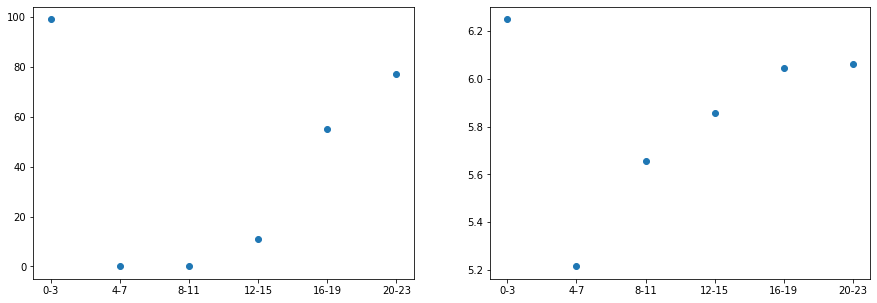

In [15]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5))


ax1.scatter([i for i in d_count.keys()],d_count.values())
ax2.scatter([i for i in d.keys()],ratingPerBin)

#normalize it by participant/nr of focus session
#nr of messages received/nr of focus session
